 # Regularity (?) of solutions to the "polygonal" Cheeger problem

In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import quadpy

from math import exp, pi, cos, sin
from numba import jit, prange
from pycheeger import SimpleSet, compute_cheeger, plot_simple_set

In [2]:
warnings.filterwarnings("ignore")

We first define the weight function which is $$\eta(x)=\text{exp}\left(-\frac{||x||^2}{2\sigma^2}\right)$$
Recall that we are looking for polygons that will approximate solutions of $$\underset{E\subset\Omega}{\text{inf}}\frac{P(E)}{\int_{E}\eta}$$

At optimality, for each $i$, the following relation should hold :
$$-(t_{i,1}+t_{i,2})=\frac{P(E)}{\int_{E}\eta}\,(w_{i,1}\nu_{i,1}+w_{i,2}\nu_{i,2})$$
with $t_{i,1}$ and $t_{i,2}$ the two tangent vectors steming from the $i$-th vertex, and $\nu_{i,1}$, $\nu_{i,2}$ the two outgoing normals of the edges steming from the $i$-th vertex, and 
$$w_{i,1}=\int_{[x_{i-1},x_i]}\eta(x)\,\frac{||x-x_{i-1}||}{||x_i-x_{i-1}||}\,dx ~~~~~~~~~~
w_{i,2}=\int_{[x_{i},x_{i+1}]}\eta(x)\,\frac{||x-x_{i+1}||}{||x_i-x_{i+1}||}\,dx$$
<br/><br/>
This equality implies in particular that $w_{i,1}=w_{i,2}\overset{\text{def}}{=}w_i$ and 
$$w_i=\frac{\int_{E}\eta}{P(E)}\,\text{tan}\left(\frac{\theta}{2}\right)$$ with $\theta$ the angle between the two edge vectors steming from the $i$-th vertex.
<br/><br/>
For a $n$-gon we have $\theta=\frac{2\pi}{n}$

In [3]:
std = 0.3


@jit(nopython=True, parallel=True)
def eta_aux(x, res):
    for i in prange(x.shape[0]):
        squared_norm = x[i, 0] ** 2 + x[i, 1] ** 2
        res[i] += exp(-squared_norm / (2 * std**2))


def eta(x):
    if x.ndim == 1:
        tmp = np.zeros(1)
        eta_aux(np.reshape(x, (1, 2)), tmp)
        res = tmp[0]
    else:
        res = np.zeros(x.shape[0])
        eta_aux(x, res)
    return res

# Case of a triangle

Weird initialization to be sure the result of the local descent does not depend too much on the initialization

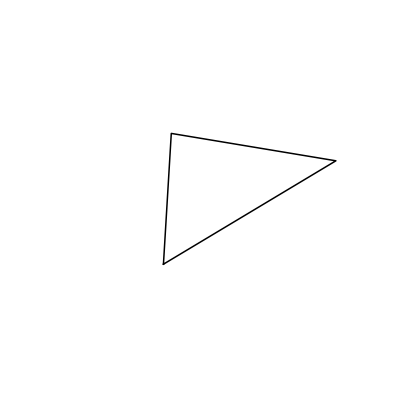

In [4]:
theta = pi / 3
rot = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
boundary_vertices = (rot @ np.array([[-0.4, 0], [0.2, 0.3], [0.5, -0.5]]).T).T
simple_set = SimpleSet(boundary_vertices)

plot_simple_set(simple_set)

In [5]:
num_boundary_vertices = 3
max_tri_area = None
step_size = 1e-3
max_iter = 2000
convergence_tol = 1e-3
num_iter_resampling = None

obj_tab, grad_norm_tab = simple_set.perform_gradient_descent(eta, step_size, max_iter, convergence_tol, 
                                                             num_boundary_vertices, max_tri_area, 
                                                             num_iter_resampling)

The optimal set looks (as expected) like an equilateral triangle

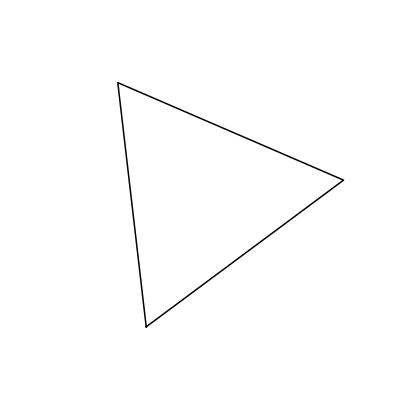

In [6]:
plot_simple_set(simple_set)

It is indeed almost equilateral and centered at the origin

In [7]:
vertices = simple_set.boundary_vertices
print("length of each edge: {}".format(np.linalg.norm(np.roll(vertices, -1, axis=0) - vertices, axis=1)))
print("distance of each vertex to the origin: {}".format(np.linalg.norm(vertices, axis=1)))

length of each edge: [1.25864687 1.25914369 1.25916664]
distance of each vertex to the origin: [0.72670264 0.7266875  0.72723708]


The gradient of the objective does not become arbitrarily small ...

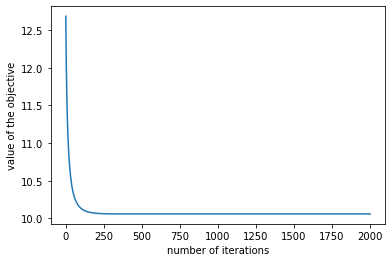

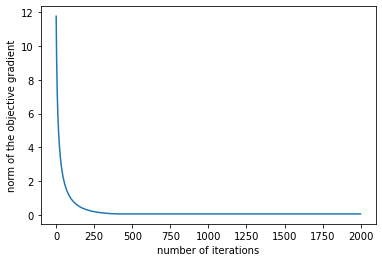

In [8]:
plt.plot(obj_tab)
plt.xlabel('number of iterations')
plt.ylabel('value of the objective')
plt.show();

plt.plot(grad_norm_tab)
plt.xlabel('number of iterations')
plt.ylabel('norm of the objective gradient')
plt.show();

In [9]:
scheme = quadpy.c1.gauss_patterson(6)
theta = 2 * np.pi / len(vertices)

i = 0

length_edge1 = np.linalg.norm(vertices[i]-vertices[i-1])
length_edge2 = np.linalg.norm(vertices[i+1]-vertices[i])

w1 = length_edge1 * \
     scheme.integrate(lambda t: eta(np.outer(1-t, vertices[i]) + np.outer(t, vertices[i-1])) * (1-t), [0, 1])

w2 = length_edge1 * \
     scheme.integrate(lambda t: eta(np.outer(1-t, vertices[i]) + np.outer(t, vertices[i+1])) * (1-t), [0, 1])

print("first weight: {}".format(w1))
print("second weight: {}\n".format(w2))

r = np.linalg.norm(vertices[i])

rhs = np.tan(theta / 2) * simple_set.compute_weighted_area(eta) / simple_set.compute_perimeter()

print("right hand side of the optimality condition: {}\n".format(rhs))

print("relative error: {}".format(np.abs(w1 - rhs) / w1))

first weight: 0.17408010829826842
second weight: 0.17413720552134818

right hand side of the optimality condition: 0.17218704864278353

relative error: 0.010874646586509053


Optimality condition only satisfied with a relative error of 1% ...

# Case of a quadrilateral

Weird initialization (again)

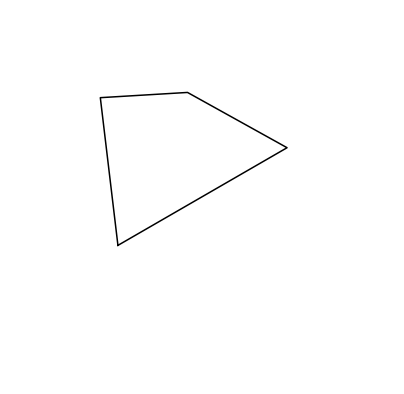

In [10]:
theta = pi / 6
rot = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
boundary_vertices = (rot @ np.array([[-0.5, 0], [0.5, 0], [0.2, 0.5], [-0.2, 0.7]]).T).T
simple_set = SimpleSet(boundary_vertices)

plot_simple_set(simple_set)

In [11]:
num_boundary_vertices = 4 
max_tri_area = None
step_size = 5e-3
max_iter = 2000
convergence_tol = 1e-3
num_iter_resampling = None

obj_tab, grad_norm_tab = simple_set.perform_gradient_descent(eta, step_size, max_iter, convergence_tol, 
                                                             num_boundary_vertices, max_tri_area, 
                                                             num_iter_resampling)

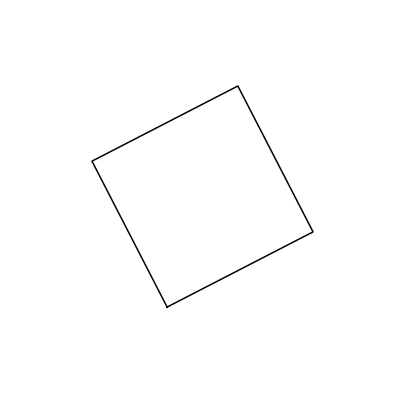

In [12]:
plot_simple_set(simple_set)

The optimal set is a rectangle as expected

In [13]:
vertices = simple_set.boundary_vertices
print("length of each edge: {}".format(np.linalg.norm(np.roll(vertices, -1, axis=0) - vertices, axis=1)))
print("distance of each vertex to the origin: {}".format(np.linalg.norm(vertices, axis=1)))

length of each edge: [0.84057235 0.84034303 0.84015076 0.84038098]
distance of each vertex to the origin: [0.59425472 0.59424987 0.59419632 0.59420116]


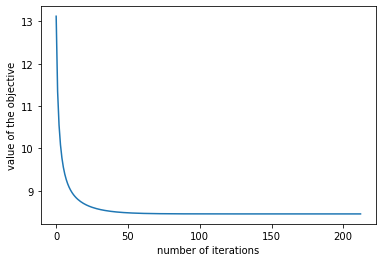

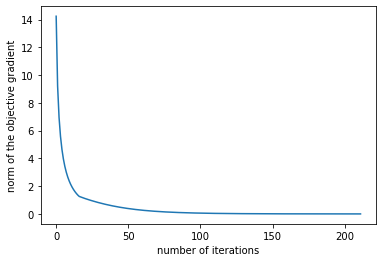

In [14]:
plt.plot(obj_tab)
plt.xlabel('number of iterations')
plt.ylabel('value of the objective')
plt.show();

plt.plot(grad_norm_tab)
plt.xlabel('number of iterations')
plt.ylabel('norm of the objective gradient')
plt.show();

In [15]:
scheme = quadpy.c1.gauss_patterson(6)
vertices = simple_set.boundary_vertices
theta = 2 * np.pi / len(vertices)

i = 0

length_edge1 = np.linalg.norm(vertices[i]-vertices[i-1])
length_edge2 = np.linalg.norm(vertices[i+1]-vertices[i])

w1 = length_edge1 * \
     scheme.integrate(lambda t: eta(np.outer(1-t, vertices[i]) + np.outer(t, vertices[i-1])) * (1-t), [0, 1])

w2 = length_edge1 * \
     scheme.integrate(lambda t: eta(np.outer(1-t, vertices[i]) + np.outer(t, vertices[i+1])) * (1-t), [0, 1])

print("first weight: {}".format(w1))
print("second weight: {}\n".format(w2))

r = np.linalg.norm(vertices[i])

rhs = np.tan(theta / 2) * simple_set.compute_weighted_area(eta) / simple_set.compute_perimeter()

print("right hand side of the optimality condition: {}\n".format(rhs))

print("relative error: {}".format(np.abs(w1 - rhs) / w1))

first weight: 0.1182479010047032
second weight: 0.1182730935328731

right hand side of the optimality condition: 0.1182494388704531

relative error: 1.3005438040181864e-05


The equality condition is almost exactly satisfied

# Case of a n-gon with large n

In [16]:
simple_set, obj_tab, grad_norm_tab = compute_cheeger(eta,
                                                     max_tri_area_fm=5e-3, max_iter_fm=10000, 
                                                     plot_results_fm=False, num_boundary_vertices_ld=50, 
                                                     max_tri_area_ld=5e-3, step_size_ld=3e-3, max_iter_ld=3000, 
                                                     convergence_tol_ld=1e-3, num_iter_resampling_ld=200, 
                                                     plot_results_ld=False)

The optimal set looks (as expected) like a circle

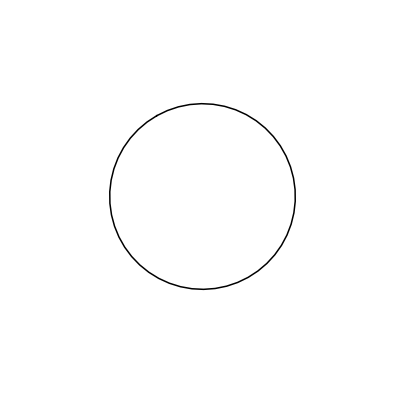

In [17]:
plot_simple_set(simple_set)

The plots below look nice, even though convergence is a bit slow ...

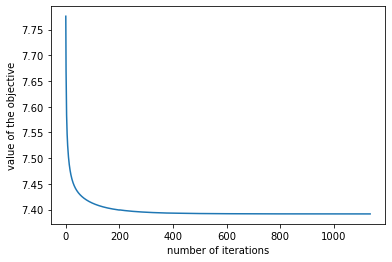

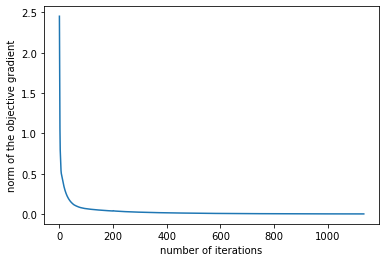

In [18]:
plt.plot(obj_tab)
plt.xlabel('number of iterations')
plt.ylabel('value of the objective')
plt.show();

plt.plot(grad_norm_tab)
plt.xlabel('number of iterations')
plt.ylabel('norm of the objective gradient')
plt.show();

In [19]:
scheme = quadpy.c1.gauss_patterson(6)
vertices = simple_set.boundary_vertices
theta = 2 * np.pi / len(vertices)

i = 0

length_edge1 = np.linalg.norm(vertices[i]-vertices[i-1])
length_edge2 = np.linalg.norm(vertices[i+1]-vertices[i])

w1 = length_edge1 * \
     scheme.integrate(lambda t: eta(np.outer(1-t, vertices[i]) + np.outer(t, vertices[i-1])) * (1-t), [0, 1])

w2 = length_edge1 * \
     scheme.integrate(lambda t: eta(np.outer(1-t, vertices[i]) + np.outer(t, vertices[i+1])) * (1-t), [0, 1])

print("first weight: {}".format(w1))
print("second weight: {}\n".format(w2))

r = np.linalg.norm(vertices[i])

rhs = np.tan(theta / 2) * simple_set.compute_weighted_area(eta) / simple_set.compute_perimeter()

print("right hand side of the optimality condition: {}\n".format(rhs))

print("relative error: {}".format(np.abs(w1 - rhs) / w1))

first weight: 0.008525530683055798
second weight: 0.008525207413364688

right hand side of the optimality condition: 0.00851156230817005

relative error: 0.001638417056372659


The equality condition is indeed approximately satisfied